In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF, LatentDirichletAllocation
from gensim import corpora, models

import nltk

# The Problem:

Project Gutenberg has thousands of books all organized, recorded and contributed by volunteers, all available for free. This is an honorable venture, but a challenging one. Because actual money is extremely limited (PG is maintained by a foundation that runs exclusively on donations) PG can't afford to hire lots of "digital librarians" to help organize and maintain the archives. 

For the most part, PG's internal resources do a good job organizing and standardizing books that are contributed by volunteers. This includes standardizing across file types, adding licenses, attribution and sourcing, while also checking that books are actually legally allowed to be free. 

One major problem is out of PG's reach, however: the amount of people reading ebooks is going up, but PG doesn't have any money in the budget to advertise their thousands of free books to the public. To survive and thrive, PG must discover a way to provide services and outreach to readers.

We need to discover a way to help readers find books they want to read in the PG database.

# The Solution:

Amazon.com, the leader of digital books, has a pretty good model. Their recommendation system does a great job suggesting books for people to read. However, that engine is driven off of user sales data and sentiment analysis on reviews. PG doesn't have that kind of stuff!

What PG does have, however, is the full, unadulterated text of thousands of books. What if we could create a recommendation system for users? Based off the text of the books, that could help users navigate lots of older (and often obscure) books.

An analysis like this could help identify natural "genres" within PG's vast stores of books, and readers that like certain books can find other similar ones this way. 

This is the start of a Natural Language Processing analysis, using K-Means Clustering and LDA to create clusters of a small training set of books.

For training, I have a list of 6300 books of various predescribed genres: fantasy, science fiction, romance and westerns, to name a few. 

I chose a small set of that, 93 titles, to train an unsupervised model. 

This list represents an index of 6300 books from Gutenberg. The order is a potential problem, 
so randomly select 50 books from the set to train on. 

In [ ]:
total_book_list = [4, 6, 8, 9, 11, 12, 13, 18, 19, 20, 24, 26, 27, 32, 33, 35, 36, 41, 42, 43, 44, 45, 46, 47, 50, 51, 54, 55, 58, 62, 64, 68, 70, 71, 72, 74, 76, 77, 78, 81, 82, 83, 84, 85, 86, 90, 91, 92, 93, 94, 95, 96, 98, 102, 103, 106, 107, 108, 110, 113, 119, 120, 122, 123, 126, 127, 128, 130, 132, 135, 136, 137, 139, 140, 142, 143, 145, 146, 147, 149, 153, 154, 155, 157, 159, 163, 164, 166, 168, 170, 172, 173, 175, 176, 177, 178, 179, 204, 205, 208, 209, 210, 211, 213, 214, 215, 221, 223, 224, 225, 236, 241, 242, 243, 244, 245, 261, 263, 264, 267, 269, 278, 280, 281, 283, 284, 285, 288, 290, 294, 295, 304, 305, 306, 307, 308, 310, 311, 313, 314, 316, 318, 319, 322, 323, 325, 326, 327, 329, 330, 331, 332, 333, 334, 335, 342, 343, 344, 345, 346, 354, 355, 356, 358, 363, 364, 365, 366, 368, 369, 370, 371, 372, 373, 374, 375, 376, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 393, 394, 396, 397, 398, 400, 403, 404, 405, 407, 411, 413, 415, 416, 419, 420, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 436, 438, 439, 441, 442, 446, 456, 457, 458, 459, 460, 464, 465, 469, 470, 471, 472, 476, 478, 479, 482, 484, 485, 486, 487, 492, 497, 498, 499, 502, 503, 504, 505, 506, 507, 508, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 524, 529, 534, 535, 536, 537, 538, 540, 541, 543, 544, 545, 547, 550, 551, 552, 553, 555, 556, 557, 558, 559, 560, 561, 562, 564, 565, 575, 577, 580, 583, 587, 588, 589, 591, 596, 599, 600, 601, 603, 604, 605, 606, 608, 611, 614, 616, 619, 620, 621, 622, 623, 627, 636, 637, 640, 641, 642, 643, 644, 645, 646, 647, 648, 650, 651, 652, 653, 674, 675, 676, 678, 688, 689, 690, 691, 692, 697, 698, 699, 700, 704, 706, 707, 708, 709, 710, 711, 713, 714, 715, 716, 718, 719, 721, 723, 724, 725, 726, 727, 728, 730, 737, 738, 739, 741, 742, 744, 746, 747, 748, 751, 753, 755, 762, 763, 765, 766, 770, 772, 775, 776, 777, 778, 780, 783, 786, 788, 793, 794, 805, 807, 808, 809, 810, 814, 815, 816, 818, 819, 820, 821, 824, 829, 832, 834, 836, 837, 838, 839, 840, 841, 843, 845, 846, 848, 849, 851, 855, 856, 857, 858, 861, 864, 865, 866, 867, 868, 869, 870, 872, 874, 876, 877, 880, 882, 883, 884, 888, 897, 898, 899, 903, 906, 907, 908, 910, 911, 912, 913, 914, 916, 917, 918, 922, 923, 924, 927, 928, 932, 935, 936, 938, 939, 940, 942, 943, 944, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 967, 968, 972, 973, 976, 977, 983, 985, 986, 1013, 1014, 1020, 1022, 1023, 1024, 1025, 1027, 1029, 1032, 1033, 1035, 1036, 1038, 1040, 1041, 1042, 1044, 1045, 1046, 1047, 1048, 1050, 1054, 1056, 1059, 1060, 1062, 1074, 1075, 1078, 1080, 1081, 1082, 1086, 1088, 1089, 1090, 1093, 1095, 1096, 1097, 1099, 1138, 1139, 1144, 1145, 1146, 1147, 1149, 1153, 1156, 1157, 1159, 1160, 1161, 1162, 1163, 1164, 1168, 1182, 1183, 1187, 1188, 1189, 1190, 1193, 1195, 1196, 1197, 1198, 1203, 1204, 1206, 1207, 1208, 1209, 1213, 1214, 1215, 1217, 1219, 1220, 1221, 1223, 1227, 1228, 1230, 1231, 1237, 1238, 1239, 1242, 1248, 1261, 1262, 1263, 1264, 1268, 1269, 1270, 1271, 1277, 1278, 1281, 1282, 1283, 1284, 1285, 1289, 1294, 1297, 1299, 1300, 1302, 1305, 1307, 1312, 1313, 1314, 1315, 1317, 1319, 1321, 1323, 1324, 1326, 1331, 1332, 1333, 1334, 1340, 1343, 1344, 1345, 1348, 1349, 1350, 1352, 1353, 1354, 1355, 1356, 1357, 1361, 1362, 1363, 1364, 1365, 1366, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1380, 1381, 1382, 1383, 1389, 1391, 1392, 1393, 1394, 1395, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1413, 1414, 1415, 1416, 1417, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1431, 1432, 1433, 1435, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1447, 1449, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1465, 1467, 1470, 1472, 1473, 1474, 1475, 1477, 1481, 1482, 1487, 1491, 1492, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1550, 1551, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1561, 1562, 1564, 1567, 1569, 1577, 1583, 1585, 1586, 1587, 1588, 1590, 1594, 1595, 1596, 1597, 1601, 1603, 1604, 1605, 1606, 1607, 1614, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1633, 1638, 1639, 1640, 1641, 1644, 1645, 1646, 1649, 1651, 1652, 1654, 1655, 1659, 1660, 1661, 1667, 1668, 1669, 1671, 1675, 1678, 1680, 1683, 1684, 1685, 1686, 1688, 1690, 1692, 1693, 1695, 1696, 1698, 1699, 1700, 1701, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1713, 1714, 1715, 1717, 1718, 1719, 1720, 1721, 1723, 1724, 1729, 1730, 1732, 1733, 1734, 1737, 1740, 1742, 1743, 1745, 1746, 1747, 1748, 1749, 1751, 1753, 1754, 1755, 1756, 1760, 1761, 1762, 1763, 1764, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1826, 1827, 1828, 1832, 1833, 1834, 1835, 1836, 1837, 1841, 1842, 1843, 1846, 1848, 1849, 1850, 1852, 1853, 1854, 1855, 1856, 1858, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1873, 1874, 1878, 1880, 1881, 1882, 1883, 1884, 1887, 1889, 1892, 1895, 1898, 1899, 1901, 1902, 1905, 1907, 1908, 1912, 1913, 1915, 1916, 1917, 1918, 1921, 1923, 1924, 1925, 1926, 1927, 1928, 1931, 1933, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1947, 1950, 1952, 1953, 1954, 1955, 1957, 1960, 1961, 1963, 1965, 1966, 1967, 1968, 1969, 1970, 1973, 1975, 1976, 1985, 1990, 1991, 1993, 1994, 2004, 2005, 2006, 2009, 2010, 2011, 2015, 2018, 2019, 2020, 2022, 2023, 2024, 2028, 2033, 2034, 2036, 2037, 2039, 2042, 2044, 2046, 2048, 2050, 2051, 2052, 2055, 2057, 2060, 2063, 2064, 2066, 2068, 2070, 2072, 2073, 2081, 2082, 2083, 2087, 2088, 2089, 2095, 2097, 2098, 2125, 2126, 2129, 2130, 2134, 2138, 2140, 2141, 2142, 2145, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2157, 2158, 2159, 2163, 2164, 2165, 2166, 2171, 2175, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2192, 2193, 2195, 2197, 2225, 2226, 2227, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2289, 2291, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2307, 2309, 2310, 2315, 2316, 2318, 2324, 2325, 2327, 2328, 2329, 2334, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2353, 2354, 2355, 2356, 2358, 2360, 2366, 2368, 2369, 2370, 2372, 2373, 2377, 2381, 2385, 2389, 2391, 2392, 2393, 2394, 2395, 2396, 2398, 2399, 2415, 2416, 2417, 2422, 2425, 2426, 2427, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2440, 2444, 2446, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2459, 2460, 2463, 2467, 2471, 2472, 2473, 2479, 2482, 2483, 2485, 2488, 2495, 2496, 2497, 2498, 2501, 2502, 2506, 2507, 2508, 2511, 2512, 2514, 2516, 2518, 2520, 2521, 2522, 2523, 2524, 2525, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2537, 2539, 2541, 2542, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2554, 2555, 2556, 2559, 2560, 2561, 2562, 2563, 2566, 2567, 2569, 2570, 2571, 2572, 2574, 2589, 2590, 2594, 2596, 2597, 2598, 2599, 2600, 2602, 2604, 2605, 2607, 2608, 2610, 2611, 2618, 2619, 2620, 2621, 2622, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2645, 2646, 2648, 2649, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2661, 2662, 2665, 2666, 2667, 2671, 2672, 2673, 2674, 2675, 2676, 2683, 2684, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2695, 2696, 2697, 2698, 2699, 2700, 2702, 2703, 2705, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2736, 2739, 2740, 2761, 2762, 2763, 2764, 2765, 2767, 2768, 2769, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2781, 2783, 2784, 2786, 2787, 2788, 2789, 2792, 2793, 2794, 2796, 2797, 2798, 2799, 2801, 2804, 2806, 2807, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2821, 2823, 2828, 2829, 2830, 2832, 2833, 2834, 2836, 2841, 2842, 2843, 2844, 2845, 2851, 2852, 2853, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2867, 2869, 2870, 2871, 2872, 2874, 2875, 2876, 2883, 2884, 2886, 2891, 2892, 2893, 2895, 2897, 2898, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2943, 2946, 2948, 2950, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2990, 2993, 2994, 2996, 2997, 3003, 3004, 3005, 3006, 3011, 3012, 3013, 3014, 3015, 3016, 3027, 3028, 3029, 3030, 3031, 3035, 3039, 3041, 3044, 3045, 3046, 3047, 3049, 3050, 3051, 3054, 3056, 3058, 3067, 3069, 3070, 3075, 3091, 3093, 3094, 3095, 3096, 3097, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3137, 3138, 3140, 3145, 3146, 3147, 3148, 3149, 3153, 3155, 3157, 3159, 3162, 3163, 3166, 3167, 3168, 3169, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3229, 3230, 3231, 3233, 3236, 3237, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3255, 3258, 3263, 3265, 3269, 3280, 3281, 3282, 3285, 3287, 3288, 3289, 3290, 3293, 3294, 3301, 3302, 3303, 3304, 3309, 3311, 3312, 3314, 3315, 3316, 3319, 3321, 3322, 3324, 3326, 3327, 3328, 3329, 3334, 3336, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3412, 3413, 3416, 3418, 3419, 3421, 3422, 3423, 3427, 3430, 3431, 3432, 3454, 3457, 3459, 3462, 3463, 3464, 3466, 3467, 3469, 3471, 3475, 3478, 3479, 3480, 3483, 3484, 3485, 3486, 3487, 3488, 3490, 3492, 3493, 3494, 3495, 3499, 3525, 3526, 3530, 3531, 3532, 3533, 3536, 3539, 3540, 3541, 3543, 3544, 3545, 3550, 3604, 3605, 3606, 3607, 3612, 3615, 3616, 3618, 3619, 3620, 3621, 3622, 3623, 3626, 3627, 3630, 3631, 3632, 3633, 3634, 3637, 3638, 3639, 3640, 3641, 3643, 3646, 3647, 3648, 3649, 3653, 3654, 3655, 3656, 3657, 3658, 3660, 3667, 3668, 3669, 3670, 3671, 3676, 3679, 3681, 3682, 3683, 3684, 3686, 3687, 3688, 3690, 3691, 3694, 3695, 3699, 3700, 3702, 3704, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3715, 3716, 3717, 3718, 3719, 3720, 3723, 3724, 3725, 3727, 3728, 3731, 3732, 3734, 3735, 3736, 3737, 3738, 3739, 3741, 3742, 3743, 3746, 3748, 3753, 3754, 3755, 3756, 3757, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3769, 3770, 3771, 3775, 3776, 3777, 3779, 3780, 3781, 3782, 3786, 3787, 3788, 3789, 3790, 3791, 3795, 3796, 3797, 3802, 3803, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3815, 3816, 3817, 3818, 3819, 3824, 3825, 3827, 3828, 3829, 3830, 3832, 3833, 3834, 3837, 3838, 3839, 3840, 3841, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3931, 3932, 3933, 3934, 3954, 3955, 3956, 3957, 3986, 3987, 3988, 3989, 3990, 4002, 4003, 4004, 4007, 4008, 4009, 4010, 4011, 4019, 4020, 4021, 4023, 4024, 4027, 4029, 4030, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4043, 4044, 4046, 4048, 4049, 4052, 4056, 4057, 4058, 4059, 4060, 4062, 4064, 4066, 4068, 4069, 4070, 4071, 4074, 4075, 4077, 4081, 4082, 4087, 4088, 4092, 4093, 4094, 4095, 4096, 4099, 4201, 4203, 4207, 4208, 4210, 4212, 4215, 4217, 4220, 4221, 4222, 4224, 4225, 4227, 4228, 4230, 4232, 4233, 4237, 4244, 4245, 4249, 4261, 4262, 4263, 4264, 4265, 4266, 4268, 4269, 4270, 4273, 4274, 4275, 4276, 4277, 4278, 4279, 4283, 4284, 4287, 4289, 4293, 4294, 4295, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4323, 4324, 4326, 4327, 4337, 4338, 4339, 4342, 4343, 4346, 4349, 4350, 4351, 4354, 4355, 4356, 4357, 4358, 4359, 4362, 4366, 4368, 4378, 4379, 4384, 4385, 4387, 4388, 4393, 4397, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 4453, 4454, 4455, 4456, 4457, 4458, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4472, 4473, 4474, 4475, 4476, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497, 4498, 4499, 4500, 4506, 4507, 4510, 4511, 4512, 4513, 4514, 4515, 4517, 4518, 4519, 4524, 4526, 4530, 4532, 4533, 4534, 4535, 4536, 4537, 4539, 4540, 4541, 4543, 4544, 4547, 4549, 4550, 4552, 4558, 4582, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4591, 4592, 4594, 4595, 4599, 4600, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4611, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4625, 4626, 4627, 4628, 4629, 4630, 4631, 4632, 4633, 4634, 4635, 4637, 4639, 4640, 4642, 4645, 4646, 4652, 4654, 4655, 4671, 4673, 4674, 4675, 4676, 4678, 4679, 4682, 4684, 4695, 4696, 4697, 4702, 4703, 4704, 4707, 4711, 4714, 4716, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4728, 4730, 4734, 4735, 4737, 4738, 4739, 4743, 4744, 4745, 4747, 4748, 4756, 4757, 4758, 4761, 4763, 4764, 4765, 4766, 4770, 4774, 4776, 4781, 4782, 4783, 4789, 4790, 4793, 4795, 4796, 4797, 4798, 4799, 4800, 4902, 4904, 4905, 4908, 4913, 4914, 4917, 4918, 4920, 4922, 4923, 4925, 4926, 4927, 4928, 4929, 4930, 4939, 4941, 4943, 4953, 4956, 4957, 4960, 4961, 4964, 4965, 4966, 4969, 4975, 4981, 4987, 4988, 4990, 4993, 4994, 4997, 5001, 5007, 5013, 5014, 5019, 5021, 5023, 5024, 5025, 5027, 5028, 5029, 5034, 5042, 5044, 5051, 5054, 5055, 5056, 5057, 5058, 5059, 5060, 5062, 5065, 5066, 5067, 5068, 5069, 5070, 5071, 5073, 5076, 5077, 5078, 5083, 5084, 5086, 5087, 5088, 5091, 5093, 5094, 5098, 5099, 5101, 5102, 5109, 5111, 5112, 5113, 5116, 5117, 5118, 5125, 5127, 5132, 5134, 5136, 5137, 5140, 5143, 5148, 5149, 5150, 5151, 5152, 5153, 5155, 5157, 5159, 5163, 5164, 5166, 5171, 5172, 5174, 5175, 5177, 5179, 5183, 5191, 5194, 5195, 5199, 5202, 5205, 5207, 5211, 5226, 5227, 5228, 5230, 5231, 5232, 5233, 5234, 5235, 5236, 5237, 5238, 5239, 5241, 5242, 5243, 5244, 5245, 5247, 5248, 5252, 5253, 5255, 5256, 5260, 5261, 5264, 5265, 5268, 5269, 5270, 5271, 5272, 5273, 5301, 5302, 5303, 5304, 5309, 5311, 5312, 5315, 5317, 5320, 5328, 5332, 5333, 5335, 5338, 5340, 5341, 5342, 5343, 5352, 5353, 5354, 5355, 5356, 5357, 5358, 5359, 5360, 5361, 5362, 5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371, 5372, 5373, 5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386, 5387, 5388, 5389, 5390, 5391, 5392, 5393, 5394, 5395, 5396, 5397, 5398, 5399, 5400, 5405, 5406, 5408, 5409, 5410, 5411, 5412, 5413, 5414, 5415, 5416, 5418, 5421, 5424, 5428, 5429, 5430, 5433, 5436, 5437, 5439, 5440, 5441, 5442, 5443, 5444, 5445, 5446, 5447, 5448, 5449, 5450, 5451, 5452, 5453, 5454, 5455, 5456, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465, 5466, 5467, 5468, 5469, 5470, 5471, 5472, 5473, 5474, 5475, 5476, 5477, 5478, 5479, 5480, 5481, 5482, 5483, 5484, 5485, 5486, 5487, 5488, 5489, 5490, 5491, 5492, 5493, 5494, 5495, 5496, 5497, 5498, 5499, 5500, 5501, 5502, 5503, 5504, 5505, 5506, 5507, 5508, 5509, 5510, 5511, 5512, 5513, 5514, 5515, 5516, 5517, 5518, 5519, 5520, 5521, 5522, 5523, 5524, 5525, 5526, 5527, 5528, 5529, 5530, 5531, 5532, 5533, 5534, 5535, 5536, 5537, 5538, 5539, 5540, 5541, 5542, 5543, 5544, 5545, 5546, 5547, 5548, 5549, 5550, 5551, 5552, 5553, 5554, 5555, 5556, 5557, 5558, 5559, 5560, 5561, 5562, 5563, 5564, 5565, 5566, 5567, 5568, 5569, 5570, 5571, 5572, 5573, 5574, 5575, 5576, 5577, 5578, 5579, 5580, 5581, 5582, 5583, 5584, 5585, 5586, 5587, 5588, 5589, 5590, 5591, 5592, 5593, 5594, 5595, 5596, 5597, 5598, 5599, 5604, 5605, 5606, 5610, 5614, 5615, 5617, 5618, 5620, 5622, 5625, 5629, 5630, 5631, 5633, 5636, 5642, 5643, 5651, 5654, 5660, 5661, 5662, 5672, 5676, 5677, 5678, 5679, 5680, 5686, 5688, 5689, 5690, 5691, 5692, 5693, 5697, 5698, 5701, 5704, 5706, 5709, 5712, 5718, 5719, 5722, 5723, 5724, 5725, 5727, 5731, 5732, 5737, 5743, 5745, 5746, 5750, 5751, 5752, 5753, 5754, 5762, 5764, 5765, 5769, 5772, 5773, 5774, 5776, 5777, 5782, 5783, 5784, 5785, 5786, 5787, 5788, 5804, 5806, 5807, 5808, 5809, 5810, 5811, 5812, 5813, 5814, 5815, 5818, 5819, 5820, 5821, 5822, 5823, 5824, 5825, 5827, 5829, 5830, 5835, 5836, 5837, 5838, 5839, 5840, 5841, 5842, 5845, 5847, 5854, 5855, 5856, 5857, 5858, 5859, 5872, 5873, 5876, 5882, 5893, 5894, 5895, 5897, 5898, 5899, 5947, 5948, 5950, 5952, 5955, 5956, 5958, 5959, 5961, 5964, 5966, 5967, 5968, 5969, 5972, 5973, 5974, 5975, 5976, 5978, 5980, 5982, 5986, 5987, 5990, 5994, 5995, 5997, 5998, 5999, 6005, 6009, 6012, 6015, 6017, 6018, 6019, 6021, 6023, 6026, 6027, 6028, 6029, 6033, 6051, 6055, 6056, 6059, 6061, 6063, 6064, 6066, 6070, 6073, 6075, 6076, 6080, 6082, 6083, 6090, 6093, 6094, 6095, 6096, 6097, 6098, 6102, 6105, 6106, 6109, 6111, 6113, 6114, 6117, 6119, 6120, 6127, 6128, 6143, 6149, 6157, 6159, 6163, 6165, 6168, 6172, 6174, 6175, 6176, 6177, 6178, 6179, 6180, 6181, 6182, 6183, 6184, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6201, 6202, 6203, 6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6248, 6249, 6250, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258, 6259, 6260, 6261, 6262, 6263, 6264, 6265, 6266, 6267, 6268, 6269, 6270, 6271, 6272, 6273, 6274, 6275, 6276, 6277, 6278, 6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 6289, 6290, 6291, 6292, 6293, 6294, 6295, 6296, 6297, 6298, 6299, 6301, 6307, 6310, 6311, 6324, 6340, 6350, 6352, 6354, 6355, 6357, 6360, 6364, 6366, 6368, 6369, 6373, 6374, 6379, 6382, 6384, 6403, 6404, 6406, 6407, 6408, 6410, 6412, 6414, 6415, 6422, 6424, 6425, 6426, 6427, 6428, 6436, 6437, 6438, 6439, 6441, 6443, 6444, 6446, 6447, 6450, 6455, 6456, 6458, 6460, 6468, 6469, 6487, 6488, 6490, 6491, 6502, 6517, 6519, 6521, 6522, 6523, 6524, 6565, 6568, 6572, 6576, 6578, 6579, 6580, 6581, 6588, 6590, 6593, 6594, 6595, 6596, 6600, 6604, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6622, 6624, 6627, 6630, 6631, 6652, 6655, 6656, 6661, 6668, 6669, 6671, 6679, 6683, 6684, 6686, 6688, 6689, 6690, 6695, 6697, 6699, 6708, 6709, 6714, 6715, 6717, 6718, 6719, 6727, 6730, 6734, 6738, 6741, 6750, 6751, 6752, 6753, 6754, 6755, 6756, 6767, 6768, 6769, 6807, 6811, 6815, 6816, 6818, 6823, 6824, 6826, 6828, 6836, 6837, 6840, 6842, 6848, 6849, 6857, 6861, 6862, 6863, 6866, 6870, 6876, 6877, 6879, 6880, 6888, 6905, 6907, 6908, 6909, 6912, 6916, 6918, 6919, 6925, 6926, 6927, 6929, 6932, 6934, 6937, 6939, 6940, 6941, 6942, 6943, 6944, 6949, 6950, 6954, 6955, 6960, 6965, 6967, 6968, 6973, 6974, 6977, 6980, 6982, 6984, 6985, 6988, 6995, 6997, 7002, 7003, 7004, 7005, 7007, 7010, 7017, 7019, 7020, 7023, 7024, 7025, 7026, 7027, 7028, 7033, 7034, 7035, 7039, 7045, 7048, 7050, 7053, 7055, 7056, 7057, 7058, 7063, 7065, 7081, 7083, 7084, 7085, 7089, 7091, 7100, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7112, 7118, 7119, 7124, 7127, 7130, 7131, 7132, 7141, 7144, 7149, 7150, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7162, 7164, 7166, 7172, 7174, 7176, 7177, 7183, 7187, 7188, 7193, 7194, 7195, 7196, 7197, 7198, 7199, 7200, 7208, 7210, 7213, 7214, 7222, 7224, 7230, 7234, 7235, 7238, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7252, 7256, 7258, 7259, 7262, 7265, 7275, 7277, 7280, 7281, 7298, 7300, 7301, 7304, 7308, 7311, 7322, 7324, 7333, 7338, 7344, 7345, 7347, 7353, 7355, 7359, 7364, 7370, 7372, 7374, 7379, 7381, 7388, 7389, 7390, 7391, 7392, 7393, 7394, 7395, 7396, 7397, 7398, 7399, 7400, 7401, 7403, 7404, 7410, 7414, 7415, 7416, 7417, 7422, 7423, 7425, 7430, 7431, 7433, 7435, 7438, 7441, 7443, 7446, 7447, 7449, 7450, 7453, 7464, 7465, 7467, 7469, 7471, 7473, 7478, 7481, 7486, 7494, 7495, 7499, 7502, 7504, 7508, 7513, 7516, 7517, 7522, 7526, 7529, 7537, 7539, 7542, 7544, 7545, 7546, 7547, 7548, 7550, 7553, 7556, 7557, 7560, 7562, 7566, 7600, 7700, 7762, 7765, 7774, 7775, 7779, 7780, 7785, 7788, 7789, 7791, 7792, 7793, 7794, 7795, 7797, 7800, 7807, 7813, 7814, 7827, 7832, 7837, 7839, 7846, 7847, 7850, 7851, 7852, 7853, 7855, 7862, 7876, 7877, 7878, 7879, 7880, 7881, 7884, 7886, 7890, 7891, 7892, 7893, 7894, 7895, 7927, 7929, 7936, 7942, 7948, 7949, 7950, 7951, 7953, 7958, 7960, 7962, 7963, 7964, 7968, 7971, 7972, 7974, 7977, 7978, 7980, 7982, 7983, 7984, 7986, 7987, 7989, 7993, 7994, 7998, 8000, 8077, 8079, 8080, 8081, 8083, 8088, 8089, 8090, 8091, 8092, 8101, 8104, 8105, 8106, 8110, 8117, 8121, 8122, 8123, 8137, 8138, 8145, 8147, 8150, 8151, 8153, 8154, 8157, 8158, 8161, 8162, 8164, 8171, 8176, 8178, 8184, 8187, 8188, 8190, 8196, 8197, 8199, 8201, 8203, 8207, 8211, 8221, 8225, 8226, 8295, 8376, 8377, 8379, 8380, 8383, 8384, 8385, 8386, 8387, 8394, 8398, 8399, 8402, 8405, 8406, 8410, 8414, 8425, 8429, 8430, 8434, 8445, 8449, 8456, 8457, 8458, 8459, 8460, 8461, 8463, 8471, 8472, 8473, 8474, 8475, 8476, 8477, 8478, 8479, 8480, 8481, 8482, 8486, 8493, 8503, 8507, 8508, 8509, 8519, 8525, 8526, 8527, 8528, 8531, 8532, 8537, 8549, 8550, 8551, 8552, 8553, 8554, 8562, 8567, 8571, 8572, 8574, 8575, 8578, 8582, 8583, 8584, 8585, 8586, 8587, 8588, 8589, 8590, 8592, 8598, 8606, 8647, 8649, 8654, 8663, 8667, 8673, 8677, 8685, 8688, 8689, 8690, 8694, 8711, 8713, 8715, 8720, 8727, 8728, 8747, 8771, 8775, 8802, 8805, 8825, 8826, 8856, 8860, 8865, 8866, 8873, 8878, 8879, 8880, 8886, 8887, 8888, 8891, 8892, 8893, 8897, 8902, 8904, 8913, 8918, 8920, 8924, 8929, 8931, 8937, 8939, 8941, 8942, 8943, 8944, 8945, 8949, 8955, 8957, 8991, 8992, 8993, 8996, 9054, 9057, 9072, 9077, 9080, 9095, 9096, 9097, 9103, 9107, 9109, 9111, 9149, 9150, 9153, 9154, 9155, 9179, 9180, 9183, 9190, 9191, 9192, 9194, 9195, 9202, 9203, 9204, 9205, 9206, 9207, 9208, 9209, 9210, 9211, 9212, 9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223, 9224, 9225, 9226, 9227, 9228, 9229, 9230, 9231, 9232, 9233, 9234, 9235, 9236, 9237, 9238, 9239, 9240, 9241, 9242, 9243, 9244, 9245, 9246, 9247, 9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9267, 9295, 9298, 9301, 9307, 9310, 9314, 9321, 9324, 9330, 9333, 9366, 9372, 9373, 9376, 9385, 9386, 9388, 9393, 9394, 9398, 9399, 9401, 9404, 9405, 9407, 9408, 9410, 9412, 9414, 9439, 9455, 9458, 9462, 9465, 9471, 9473, 9487, 9488, 9504, 9505, 9543, 9559, 9608, 9609, 9611, 9612, 9617, 9618, 9620, 9629, 9651, 9653, 9656, 9661, 9663, 9664, 9745, 9749, 9777, 9780, 9785, 9788, 9790, 9792, 9796, 9799, 9801, 9806, 9808, 9812, 9822, 9823, 9826, 9829, 9830, 9831, 9832, 9833, 9836, 9837, 9845, 9846, 9849, 9853, 9855, 9857, 9862, 9871, 9872, 9874, 9888, 9897, 9904, 9913, 9923, 9924, 9931, 9932, 9954, 9955, 9964, 9967, 9970, 9971, 9972, 9974, 9979, 9984, 9993, 9999, 10002, 10008, 10012, 10031, 10041, 10042, 10044, 10045, 10046, 10057, 10060, 10062, 10065, 10067, 10078, 10084, 10086, 10093, 10094, 10097, 10101, 10119, 10132, 10133, 10145, 10146, 10147, 10148, 10149, 10150, 10157, 10159, 10170, 10176, 10190, 10201, 10213, 10217, 10226, 10229, 10243, 10247, 10268, 10280, 10291, 10303, 10305, 10307, 10309, 10310, 10314, 10316, 10319, 10321, 10328, 10335, 10339, 10342, 10345, 10350, 10351, 10352, 10355, 10356, 10357, 10360, 10363, 10365, 10368, 10371, 10375, 10380, 10381, 10389, 10392, 10394, 10395, 10397, 10399, 10401, 10404, 10410, 10420, 10422, 10423, 10424, 10433, 10434, 10438, 10440, 10446, 10451, 10452, 10461, 10463, 10465, 10466, 10473, 10476, 10482, 10490, 10493, 10521, 10534, 10537, 10540, 10541, 10542, 10543, 10545, 10546, 10547, 10548, 10551, 10552, 10554, 10575, 10576, 10578, 10581, 10582, 10584, 10586, 10591, 10592, 10593, 10600, 10605, 10606, 10608, 10610, 10615, 10616, 10624, 10625, 10658, 10659, 10660, 10662, 10671, 10679, 10690, 10696, 10698, 10707, 10714, 10715, 10731, 10732, 10733, 10736, 10738, 10739, 10740, 10741, 10742, 10745, 10755, 10760, 10761, 10762, 10765, 10767, 10776, 10797, 10803, 10804, 10809, 10810, 10815, 10817, 10818, 10830, 10832, 10833, 10835, 10839, 10842, 10852, 10853, 10855, 10857, 10862, 10866, 10881, 10882, 10884, 10892, 10897, 10901, 10911, 10919, 10928, 10929, 10938, 10942, 10948, 10951, 10956, 10958, 10962, 10966, 10968, 10970, 10973, 10977, 10984, 10986, 10988, 10997, 11008, 11012, 11016, 11019, 11021, 11034, 11041, 11050, 11051, 11052, 11054, 11057, 11063, 11074, 11077, 11079, 11086, 11089, 11090, 11102, 11104, 11105, 11106, 11119, 11121, 11125, 11127, 11128, 11130, 11135, 11137, 11144, 11145, 11147, 11153, 11160, 11161, 11164, 11174, 11192, 11198, 11202, 11203, 11213, 11216, 11223, 11228, 11238, 11239, 11240, 11243, 11247, 11248, 11252, 11254, 11260, 11263, 11278, 11280, 11289, 11303, 11304, 11309, 11311, 11314, 11324, 11328, 11329, 11351, 11354, 11357, 11360, 11365, 11368, 11371, 11372, 11376, 11377, 11397, 11402, 11403, 11409, 11410, 11413, 11414, 11424, 11426, 11438, 11448, 11451, 11464, 11483, 11490, 11493, 11496, 11501, 11502, 11503, 11504, 11505, 11506, 11507, 11510, 11532, 11546, 11547, 11554, 11556, 11557, 11560, 11561, 11573, 11574, 11579, 11582, 11594, 11602, 11603, 11605, 11614, 11618, 11623, 11626, 11632, 11633, 11639, 11640, 11641, 11643, 11654, 11656, 11665, 11666, 11668, 11671, 11673, 11686, 11694, 11696, 11698, 11702, 11715, 11716, 11722, 11729, 11730, 11733, 11749, 11752, 11757, 11758, 11759, 11768, 11772, 11774, 11866, 11867, 11870, 11876, 11878, 11881, 11882, 11890, 11896, 11901, 11909, 11911, 11913, 11934, 11938, 11945, 11957, 11961, 11962, 11977, 11984, 11987, 11988, 12001, 12010, 12024, 12028, 12031, 12032, 12033, 12037, 12044, 12046, 12047, 12048, 12050, 12051, 12052, 12067, 12069, 12078, 12085, 12089, 12100, 12102, 12104, 12139, 12142, 12162, 12163, 12170, 12171, 12176, 12187, 12189, 12190, 12191, 12192, 12193, 12196, 12197, 12199, 12218, 12225, 12228, 12229, 12234, 12245, 12248, 12252, 12256, 12259, 12261, 12264, 12277, 12278, 12298, 12300, 12311, 12313, 12315, 12316, 12317, 12318, 12320, 12325, 12329, 12330, 12334, 12336, 12337, 12346, 12350, 12353, 12375, 12377, 12380, 12387, 12388, 12400, 12406, 12419, 12420, 12421, 12424, 12429, 12431, 12433, 12440, 12441, 12442, 12443, 12445, 12452, 12453, 12454, 12458, 12460, 12470, 12471, 12474, 12475, 12476, 12482, 12491, 12494, 12495, 12506, 12509, 12510, 12512, 12514, 12523, 12525, 12528, 12532, 12535, 12544, 12545, 12548, 12555, 12556, 12557, 12565, 12570, 12571, 12578, 12580, 12584, 12585, 12586, 12587, 12590, 12606, 12610, 12611, 12621, 12623, 12626, 12628, 12632, 12643, 12649, 12652, 12653, 12654, 12656, 12657, 12658, 12663, 12668, 12671, 12673, 12674, 12678, 12681, 12682, 12686, 12687, 12689, 12690, 12691, 12692, 12694, 12700, 12728, 12729, 12730, 12731, 12734, 12735, 12742, 12743, 12746, 12750, 12753, 12754, 12755, 12764, 12769, 12771, 12773, 12774, 12775, 12776, 12777, 12778, 12779, 12784, 12787, 12793, 12794, 12798, 12805, 12806, 12807, 12810, 12811, 12813, 12819, 12820, 12821, 12830, 12835, 12842, 12845, 12849, 12852, 12854, 12855, 12858, 12859, 12861, 12868, 12870, 12871, 12876, 12882, 12885, 12891, 12896, 12900, 12901, 12902, 12912, 12915, 12920, 12922, 12923, 12938, 12939, 12945, 12946, 12947, 12948, 12962, 12963, 12964, 12968, 12971, 12972, 12976, 12977, 12983, 12986, 12989, 12990, 12991, 12992, 12994, 12995, 13001, 13003, 13005, 13006, 13009, 13012, 13015, 13020, 13021, 13040, 13042, 13043, 13045, 13047, 13050, 13055, 13057, 13068, 13076, 13084, 13085, 13086, 13095, 13097, 13115, 13123, 13128, 13130, 13135, 13138, 13151, 13152, 13155, 13159, 13161, 13169, 13170, 13172, 13184, 13194, 13201, 13203, 13206, 13218, 13225, 13235, 13237, 13239, 13243, 13245, 13254, 13257, 13260, 13273, 13279, 13286, 13287, 13290, 13292, 13293, 13296, 13310, 13312, 13324, 13329, 13332, 13333, 13334, 13340, 13342, 13343, 13345, 13347, 13349, 13350, 13356, 13364, 13365, 13366, 13368, 13369, 13372, 13381, 13387, 13397, 13408, 13409, 13410, 13412, 13413, 13414, 13415, 13416, 13417, 13418, 13419, 13423, 13430, 13433, 13434, 13449, 13464, 13467, 13468, 13483, 13484, 13494, 13498, 13499, 13505, 13506, 13509, 13514, 13515, 13522, 13526, 13527, 13531, 13533, 13537, 13541, 13542, 13552, 13554, 13555, 13556, 13560, 13561, 13574, 13582, 13588, 13589, 13597, 13606, 13621, 13652, 13667, 13670, 13672, 13677, 13688, 13689, 13694, 13707, 13709, 13718, 13722, 13723, 13739, 13746, 13749, 13757, 13767, 13775, 13799, 13811, 13812, 13826, 13830, 13833, 13836, 13844, 13852, 13854, 13858, 13860, 13872, 13878, 13881, 13882, 13883, 13894, 13897, 13900, 13908, 13909, 13913, 13928, 13932, 13933, 13937, 13940, 13957, 13958, 13969, 13970, 13982, 13984, 13985, 13996, 14003, 14006, 14016, 14021, 14026, 14032, 14044, 14052, 14060, 14065, 14068, 14072, 14080, 14084, 14085, 14089, 14091, 14106, 14108, 14109, 14133, 14136, 14137, 14145, 14150, 14167, 14168, 14169, 14171, 14176, 14179, 14188, 14191, 14203, 14206, 14211, 14216, 14218, 14226, 14228, 14238, 14239, 14243, 14246, 14253, 14255, 14274, 14275, 14276, 14279, 14294, 14295, 14297, 14298, 14299, 14303, 14316, 14334, 14352, 14353, 14360, 14367, 14369, 14392, 14395, 14402, 14405, 14409, 14411, 14414, 14416, 14418, 14423, 14426, 14429, 14432, 14436, 14437, 14442, 14444, 14449, 14451, 14453, 14456, 14457, 14461, 14464, 14465, 14471, 14472, 14481, 14486, 14487, 14490, 14497, 14506, 14510, 14511, 14513, 14520, 14526, 14527, 14532, 14533, 14535, 14540, 14542, 14558, 14562, 14563, 14572, 14573, 14574, 14576, 14577, 14582, 14584, 14588, 14593, 14594, 14595, 14598, 14599, 14600, 14602, 14611, 14613, 14614, 14618, 14623, 14624, 14625, 14629, 14640, 14642, 14653, 14654, 14655, 14658, 14659, 14664, 14665, 14668, 14669, 14674, 14682, 14697, 14706, 14721, 14723, 14740, 14755, 14759, 14762, 14766, 14811, 14817, 14841, 14849, 14857, 14860, 14866, 14867, 14876, 14880, 14882, 14884, 14888, 14890, 14891, 14898, 14907, 14943, 14960, 14961, 14975, 14976, 14977, 14984, 14998, 15002, 15003, 15005, 15007, 15014, 15033, 15034, 15035, 15040, 15042, 15044, 15055, 15063, 15072, 15076, 15079, 15086, 15089, 15094, 15097, 15098, 15100, 15103, 15108, 15116, 15118, 15120, 15122, 15124, 15130, 15132, 15134, 15138, 15145, 15148, 15154, 15155, 15161, 15167, 15169, 15176, 15187, 15189, 15192, 15205, 15220, 15222, 15223, 15228, 15237, 15238, 15244, 15246, 15253, 15254, 15255, 15257, 15266, 15269, 15275, 15279, 15285, 15289, 15293, 15299, 15300, 15302, 15308, 15317, 15321, 15323, 15336, 15348, 15351, 15353, 15357, 15363, 15376, 15380, 15383, 15384, 15385, 15389, 15390, 15398, 15409, 15414, 15416, 15424, 15425, 15426, 15432, 15438, 15447, 15448, 15455, 15460, 15465, 15468, 15473, 15486, 15492, 15496, 15502, 15503, 15508, 15519, 15520, 15522, 15524, 15525, 15528, 15529, 15537, 15540, 15542, 15545, 15546, 15561, 15563, 15565, 15566, 15571, 15577, 15580, 15596, 15599, 15607, 15608, 15614, 15616, 15618, 15625, 15630, 15644, 15651, 15659, 15660, 15664, 15665, 15671, 15673, 15689, 15694, 15697, 15698, 15707, 15710, 15712, 15717, 15722, 15728, 15733, 15735, 15737, 15741, 15744, 15746, 15750, 15752, 15755, 15760, 15762, 15766, 15767, 15768, 15775, 15777, 15779, 15780, 15792, 15793, 15794, 15796, 15802, 15803, 15807, 15808, 15810, 15825, 15830, 15831, 15852, 15854, 15856, 15857, 15862, 15863, 15864, 15865, 15867, 15868, 15869, 15872, 15874, 15875, 15878, 15888, 15893, 15894, 15899, 15901, 15905, 15906, 15920, 15931, 15936, 15938, 15950, 15955, 15964, 15965, 15966, 15976, 15977, 15978, 15979, 15984, 15992, 15997, 15998, 16000, 16027, 16041, 16044, 16046, 16048, 16051, 16053, 16054, 16065, 16070, 16076, 16079, 16085, 16090, 16091, 16097, 16100, 16129, 16131, 16134, 16136, 16137, 16138, 16144, 16145, 16146, 16148, 16150, 16155, 16160, 16168, 16170, 16174, 16178, 16186, 16194, 16205, 16206, 16229, 16231, 16249, 16251, 16257, 16259, 16265, 16267, 16269, 16283, 16287, 16288, 16291, 16299, 16303, 16307, 16308, 16309, 16310, 16320, 16334, 16338, 16339, 16340, 16344, 16362, 16369, 16375, 16379, 16381, 16387, 16407, 16410, 16419, 16424, 16427, 16438, 16442, 16457, 16466, 16470, 16471, 16474, 16488, 16491, 16493, 16494, 16497, 16508, 16516, 16519, 16525, 16529, 16530, 16541, 16546, 16548, 16549, 16553, 16554, 16560, 16570, 16578, 16579, 16589, 16595, 16596, 16600, 16603, 16604, 16611, 16614, 16615, 16616, 16627, 16662, 16663, 16675, 16688, 16690, 16691, 16695, 16703, 16713, 16715, 16716, 16720, 16724, 16726, 16729, 16730, 16733, 16735, 16736, 16737, 16739, 16742, 16745, 16751, 16756, 16769, 16798, 16800, 16804, 16809, 16821, 16847, 16860, 16866, 16867, 16870, 16871, 16879, 16890, 16898, 16908, 16911, 16912, 16913, 16916, 16918, 16928, 16931, 16932, 16936, 16937, 16946, 16951, 16956, 16962, 16966, 16967, 16971, 16975, 16976, 16981, 16993, 16995, 16996, 16998, 17006, 17008, 17014, 17016, 17031, 17040, 17041, 17042, 17043, 17047, 17053, 17061, 17063, 17064, 17066, 17075, 17085, 17088, 17090, 17093, 17094, 17095, 17096, 17097, 17100, 17102, 17103, 17117, 17118, 17119, 17131, 17133, 17134, 17135, 17145, 17151, 17152, 17157, 17159, 17164, 17165, 17168, 17170, 17176, 17178, 17188, 17190, 17192, 17197, 17203, 17205, 17214, 17221, 17222, 17226, 17228, 17237, 17241, 17260, 17262, 17263, 17272, 17276, 17277, 17278, 17282, 17283, 17301, 17314, 17333, 17342, 17350, 17352, 17355, 17356, 17359, 17368, 17370, 17382, 17386, 17396, 17398, 17402, 17405, 17407, 17412, 17418, 17427, 17429, 17434, 17444, 17452, 17456, 17460, 17469, 17470, 17472, 17474, 17480, 17481, 17483, 17485, 17492, 17497, 17500, 17508, 17514, 17530, 17535, 17547, 17548, 17559, 17570, 17579, 17582, 17594, 17608, 17627, 17642, 17648, 17655, 17677, 17679, 17684, 17689, 17694, 17698, 17733, 17743, 17744, 17745, 17751, 17753, 17761, 17767, 17776, 17780, 17782, 17797, 17799, 17800, 17804, 17813, 17815, 17823, 17825, 17841, 17842, 17848, 17860, 17861, 17867, 17870, 17873, 17877, 17878, 17884, 17892, 17902, 17903, 17917, 17921, 17922, 17928, 17937, 17939, 17943, 17944, 17948, 17954, 17956, 17957, 17959, 17964, 17966, 17970, 17977, 17978, 17981, 17985, 17993, 17997, 18000, 18009, 18020, 18025, 18035, 18049, 18051, 18062, 18070, 18080, 18093, 18099, 18117, 18119, 18127, 18129, 18131, 18134, 18149, 18150, 18153, 18154, 18163, 18171, 18172, 18175, 18176, 18180, 18184, 18191, 18193, 18194, 18196, 18204, 18207, 18209, 18214, 18229, 18247, 18250, 18254, 18264, 18266, 18273, 18276, 18279, 18283, 18284, 18325, 18332, 18335, 18350, 18359, 18361, 18366, 18377, 18379, 18390, 18400, 18409, 18419, 18420, 18421, 18423, 18428, 18431, 18432, 18438, 18439, 18442, 18443, 18445, 18461, 18467, 18470, 18472, 18477, 18480, 18495, 18496, 18506, 18507, 18510, 18529, 18530, 18531, 18533, 18544, 18555, 18559, 18560, 18562, 18563, 18565, 18566, 18572, 18573, 18577, 18579, 18591, 18592, 18593, 18594, 18595, 18602, 18604, 18605, 18613, 18614, 18615, 18617, 18626, 18630, 18631, 18639, 18640, 18643, 18645, 18647, 18651, 18652, 18654, 18655, 18656, 18657, 18662, 18665, 18671, 18676, 18678, 18679, 18683, 18684, 18686, 18687, 18688, 18689, 18690, 18691, 18696, 18699, 18703, 18712, 18713, 18719, 18722, 18729, 18736, 18750, 18757, 18758, 18767, 18774, 18778, 18790, 18792, 18799, 18803, 18809, 18810, 18811, 18816, 18819, 18822, 18824, 18835, 18840, 18842, 18847, 18851, 18857, 18859, 18875, 18879, 18881, 18882, 18883, 18897, 18903, 18916, 18926, 18933, 18934, 18939, 18941, 18943, 18945, 18948, 18950, 18953, 18954, 18960, 18964, 18970, 18978, 18981, 18987, 18990, 19002, 19006, 19010, 19018, 19033, 19037, 19043, 19055, 19066, 19078, 19083, 19087, 19094, 19096, 19104, 19108, 19114, 19120, 19129, 19130, 19131, 19133, 19139, 19141, 19142, 19157, 19160, 19162, 19166, 19167, 19170, 19171, 19172, 19174, 19175, 19191, 19193, 19202, 19204, 19205, 19207, 19209, 19223, 19224, 19229, 19235, 19246, 19255, 19257, 19258, 19263, 19265, 19294, 19295, 19303, 19304, 19307, 19310, 19311, 19317, 19318, 19328, 19333, 19335, 19337, 19341, 19355, 19362, 19367, 19368, 19392, 19395, 19401, 19403, 19404, 19410, 19412, 19413, 19416, 19419, 19421, 19425, 19434, 19435, 19441, 19450, 19463, 19464, 19466, 19467, 19470, 19473, 19475, 19477, 19484, 19489, 19491, 19495, 19500, 19501, 19505, 19506, 19508, 19510, 19512, 19513, 19514, 19515, 19518, 19522, 19527, 19529, 19535, 19555, 19560, 19561, 19565, 19569, 19572, 19573, 19574, 19575, 19576, 19580, 19589, 19590, 19595, 19598, 19599, 19606, 19607, 19608, 19640, 19642, 19645, 19655, 19658, 19659, 19665, 19672, 19676, 19678, 19690, 19691, 19692, 19693, 19697, 19702, 19706, 19711, 19713, 19717, 19718, 19722, 19724, 19726, 19730, 19731, 19735, 19736, 19742, 19745, 19746, 19750, 19751, 19752, 19763, 19768, 19772, 19782, 19783, 19788, 19797, 19800, 19806, 19810, 19815, 19816, 19818, 19819, 19822, 19824, 19826, 19831, 19841, 19848, 19849, 19851, 19852, 19857, 19861, 19869, 19870, 19877, 19878, 19897, 19899, 19900, 19901, 19905, 19906, 19910, 19913, 19929, 19935, 19944, 19945, 19946, 19953, 19958, 19963, 19969, 19977, 19981, 19983, 19987, 20005, 20012, 20014, 20022, 20026, 20035, 20036, 20038, 20039, 20046, 20058, 20059, 20064, 20065, 20067, 20072, 20084, 20085, 20097, 20104, 20105, 20106, 20107, 20116, 20119, 20123, 20125, 20127, 20131, 20132, 20133, 20134, 20139, 20141, 20152, 20154, 20155, 20157, 20160, 20164, 20168, 20172, 20174, 20176, 20181, 20184, 20186, 20195, 20196, 20198, 20213, 20216, 20219, 20225, 20233, 20243, 20248, 20250, 20255, 20261, 20263, 20265, 20267, 20268, 20269, 20278, 20279, 20283, 20306, 20309, 20311, 20315, 20324, 20326, 20328, 20335, 20336, 20345, 20347, 20348, 20349, 20357, 20358, 20359, 20360, 20362, 20374, 20381, 20385, 20387, 20389, 20393, 20403, 20404, 20411, 20416, 20423, 20426, 20442, 20448, 20449, 20451, 20467, 20475, 20487, 20494, 20500, 20506, 20519, 20520, 20522, 20523, 20526, 20532, 20533, 20543, 20546, 20548, 20551, 20555, 20559, 20560, 20563, 20567, 20569, 20571, 20579, 20580, 20592, 20593, 20594, 20595, 20598, 20600, 20601, 20606, 20609, 20611, 20612, 20615, 20626, 20627, 20628, 20629, 20633, 20650, 20651, 20653, 20656, 20666, 20675, 20679, 20691, 20702, 20707, 20716, 20717, 20733, 20742, 20744, 20747, 20748, 20749, 20755, 20756, 20766, 20768, 20772, 20787, 20789, 20795, 20796, 20800, 20807, 20813, 20815, 20826, 20827, 20828, 20836, 20837, 20838, 20844, 20850, 20859, 20870, 20873, 20878, 20879, 20887, 20893, 20897, 20902, 20912, 20913, 20914, 20920, 20921, 20922, 20928, 20929, 20933, 20934, 20945, 20946, 20947, 20948, 20967, 20979, 20981, 20983, 20986, 20988, 20990, 20991, 20992, 20993, 20994, 20995, 21005, 21006, 21022, 21035, 21036, 21037, 21038, 21039, 21042, 21043, 21044, 21046, 21048, 21050, 21056, 21057, 21058, 21059, 21060, 21061, 21062, 21063, 21064, 21065, 21066, 21067, 21068, 21069, 21070, 21071, 21072, 21073, 21075, 21078, 21079, 21080, 21090, 21091, 21094]

In [ ]:
print(np.random.choice(total_book_list, size=20))

In [ ]:
The list of numbers:

1425, 8463, 3249, 7467, 3691, 7389, 7301, 1389, 19464, 13707, 5150, 604, 10352, 744, 956, 5815, 8747, 4707, 1507, 6364, 1671, 15002, 12690, 19877, 6718, 9054, 16615, 147, 5589, 4268, 8711, 8562, 12471, 6226, 3070, 9220, 3309, 2699, 7547, 8385

14755, 6519, 2081, 8081, 4619, 3353, 1522, 14471, 12044, 6967, 11376, 5581, 318, 16079, 8892, 16800, 4452, 11876, 5737, 9788, 5997, 2256, 14456, 19944, 21071, 5388, 12509, 19580, 2853, 9504, 16257, 19341, 19590, 1530, 1149, 7544, 8931, 20198, 6177, 9230, 12491, 6005, 3119, 10438, 17412, 14395, 9190, 14369, 1356, 15502

[ 5691, 3070, 4034, 5466, 1751, 11633, 6937, 19141]
14755, 6519, 2081, 8081, 4619, 3353, 1522, 14471, 12044, 6967, 11376, 5581, 318, 16079, 8892, 16800, 4452, 11876, 5737, 9788, 5997, 2256, 14456, 19944, 21071, 5388, 12509, 19580, 2853, 9504, 16257, 19341, 19590, 1530, 1149, 7544, 8931, 20198, 6177, 9230, 12491, 6005, 3119, 10438, 17412, 14395, 9190, 14369, 1356, 15502

In [2]:
numberslist = [10352, 7467, 8562, 8385, 956, 604, 6718, 744, 4707, 8711, 19464, 19877, 3249, 13707, 6364, 4268, 5150, 1671, 9220, 5815, 12690, 2602, 19362, 15728, 2279, 5338, 9806, 3280, 486, 9488, 4310, 1832, 2862, 20157, 18819, 3240, 2301, 13621, 897, 6848, 18377, 4966, 18250, 15857, 3355, 10438, 11376, 1149, 11633, 11876, 12044, 12491, 12509, 1356, 14369, 14395, 14456, 14471, 14755, 15502, 16079, 16257, 16800, 17412, 1751, 19141, 19341, 19590, 19944, 20198, 2081, 21071, 2853, 3070, 3119, 318, 3353, 4034, 4452, 4619, 5388, 5466, 5691, 5737, 6519, 7544, 8081, 8892, 8931, 9190, 9230, 9504, 9788]
titles = []
for item in numberslist:
    titles.append(str(item))
    

In [3]:
titles = sorted(titles)

In [4]:
print(len(titles))

93


In [5]:
print(titles)

['10352', '10438', '11376', '1149', '11633', '11876', '12044', '12491', '12509', '12690', '1356', '13621', '13707', '14369', '14395', '14456', '14471', '14755', '15502', '15728', '15857', '16079', '16257', '1671', '16800', '17412', '1751', '18250', '1832', '18377', '18819', '19141', '19341', '19362', '19464', '19590', '19877', '19944', '20157', '20198', '2081', '21071', '2279', '2301', '2602', '2853', '2862', '3070', '3119', '318', '3240', '3249', '3280', '3353', '3355', '4034', '4268', '4310', '4452', '4619', '4707', '486', '4966', '5150', '5338', '5388', '5466', '5691', '5737', '5815', '604', '6364', '6519', '6718', '6848', '744', '7467', '7544', '8081', '8385', '8562', '8711', '8892', '8931', '897', '9190', '9220', '9230', '9488', '9504', '956', '9788', '9806']


# fuck that let's use Gensim

This code is mostly pulled from this amazing explanation: http://brandonrose.org/clustering

In [6]:
import gensim
import os 
import re
import codecs
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity

from __future__ import print_function
import glob


import mpld3


In [7]:
path = 'data/books/'
listing = os.listdir(path)
books = []
testlist = []
for infile in listing:
    with open(infile, encoding='latin-1') as f:
        books.append(f.read())

In [8]:
# to show the titles
for infile in listing:
    with open(infile, encoding='latin-1') as f:
        testlist.append(f)

In [9]:
print(len(testlist)) #uncomment this to see the titles

93


In [10]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [11]:
list(stopwords)

['being',
 'thi',
 'copied',
 'thine',
 'all',
 'nigh',
 'aye',
 'refunded',
 'further',
 'e-book',
 'does',
 'because',
 'in',
 'is',
 'same',
 'can',
 'project',
 'his',
 'while',
 'over',
 'thy',
 'themselves',
 'yourselves',
 'had',
 "'m",
 'no',
 'll',
 'her',
 'out',
 'don',
 'when',
 'an',
 'about',
 'thou',
 'between',
 'ebook',
 'we',
 'ii',
 'to',
 'which',
 'each',
 'other',
 're',
 'will',
 'them',
 'their',
 'through',
 'how',
 's',
 'they',
 'own',
 'before',
 'herself',
 'below',
 'than',
 't',
 'himself',
 'you',
 'it',
 'yourself',
 'these',
 'of',
 'down',
 'distribute',
 'electronic',
 'for',
 'where',
 'most',
 'and',
 'gutenberg-tm',
 'from',
 'o',
 'did',
 'him',
 'archive',
 'theirs',
 'doing',
 'she',
 'having',
 'am',
 'whom',
 'was',
 'have',
 'above',
 'copy',
 'now',
 'i',
 'up',
 'with',
 'my',
 'after',
 'access',
 'trademark',
 'once',
 'by',
 'then',
 'been',
 "'i",
 'ca',
 'very',
 'literary',
 'too',
 'wi',
 'are',
 'he',
 'copyright',
 'there',
 'here

In [12]:
stemmer = SnowballStemmer("english")

In [13]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [14]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [15]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in books:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'books', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [16]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [32]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.80, max_features=200000,
                                 min_df=0.20, analyzer='word', stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(books) 

print(tfidf_matrix.shape)

CPU times: user 4min 29s, sys: 5.17 s, total: 4min 34s
Wall time: 4min 38s
(93, 11154)


In [33]:
terms = tfidf_vectorizer.get_feature_names()

In [34]:
terms

["'a",
 "'s 's",
 "'s account",
 "'s advic",
 "'s affair",
 "'s age",
 "'s alway",
 "'s ani",
 "'s anoth",
 "'s answer",
 "'s appear",
 "'s arm",
 "'s arriv",
 "'s ask",
 "'s attent",
 "'s aw",
 "'s back",
 "'s bad",
 "'s beauti",
 "'s becaus",
 "'s bed",
 "'s best",
 "'s better",
 "'s big",
 "'s blood",
 "'s bodi",
 "'s book",
 "'s boy",
 "'s brain",
 "'s breast",
 "'s brother",
 "'s busi",
 "'s call",
 "'s care",
 "'s case",
 "'s chair",
 "'s charact",
 "'s cheek",
 "'s children",
 "'s come",
 "'s comfort",
 "'s compani",
 "'s companion",
 "'s confid",
 "'s convers",
 "'s cri",
 "'s dark",
 "'s daughter",
 "'s day",
 "'s dead",
 "'s death",
 "'s desir",
 "'s differ",
 "'s done",
 "'s door",
 "'s dress",
 "'s duti",
 "'s ear",
 "'s edg",
 "'s end",
 "'s enough",
 "'s express",
 "'s face",
 "'s fair",
 "'s famili",
 "'s fate",
 "'s father",
 "'s fault",
 "'s fear",
 "'s feel",
 "'s feet",
 "'s fine",
 "'s finger",
 "'s first",
 "'s foot",
 "'s friend",
 "'s get",
 "'s go",
 "'s gone",


In [35]:
tfidf_matrix

<93x11154 sparse matrix of type '<class 'numpy.float64'>'
	with 374914 stored elements in Compressed Sparse Row format>

# HELLO

In [36]:
dist = 1 - cosine_similarity(tfidf_matrix)

# K means clustering, can you try a different type?

In [37]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
print(tfidf_matrix.shape)


CPU times: user 1.29 s, sys: 87.2 ms, total: 1.38 s
Wall time: 910 ms
(93, 11154)


In [38]:
clusters = km.labels_.tolist()

In [39]:
frame = pd.DataFrame(clusters, index = titles)

In [40]:
frame['title'] = titles

In [41]:
frame[0].value_counts()

2    54
0    17
4    10
3     8
1     4
Name: 0, dtype: int64

In [47]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :15]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
        
print()
print()

Top terms per cluster:

Cluster 0 words: b'mrs.', b"'ve", b'jane', b'doctor', b"n't", b'mary', b'wo', b'wo', b'could', b'dr.', b'london', b'stained', b'garden', b'would', b'chapter',

Cluster 1 words: b'ships', b'boat', b'board', b'sailed', b'deck', b'captains', b'vessels', b'crews', b'john', b'mate', b'saloon', b'alongside', b'craft', b'island', b'pirate',

Cluster 2 words: b'king', b'princes', b'princess', b'churches', b'queen', b'england', b'london', b'mrs.', b'smith', b'chapter', b'sister', b'christian', b'footnote', b'honour', b'de',

Cluster 3 words: b'captains', b"'ve", b'daniel', b'mrs.', b'spiked', b'dollars', b'colonel', b'goin', b"'em", b"n't", b'boston', b'dan', b"'ve", b'wo', b'wo',

Cluster 4 words: b'jim', b'tom', b"'ve", b'jack', b'camp', b'trailed', b'scouts', b'wagon', b'mrs.', b'rivers', b'aunt', b'sandys', b'wo', b"'ve", b'wo',





# Multidimensional scaling

In [43]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

In [50]:
MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

# Visualizing

In [57]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Working-class England', 
                 1: 'Manly men on the high seas', 
                 2: 'Political and court intrigue', 
                 3: 'Soldiers and warfare', 
                 4: 'Travel and adventure'}

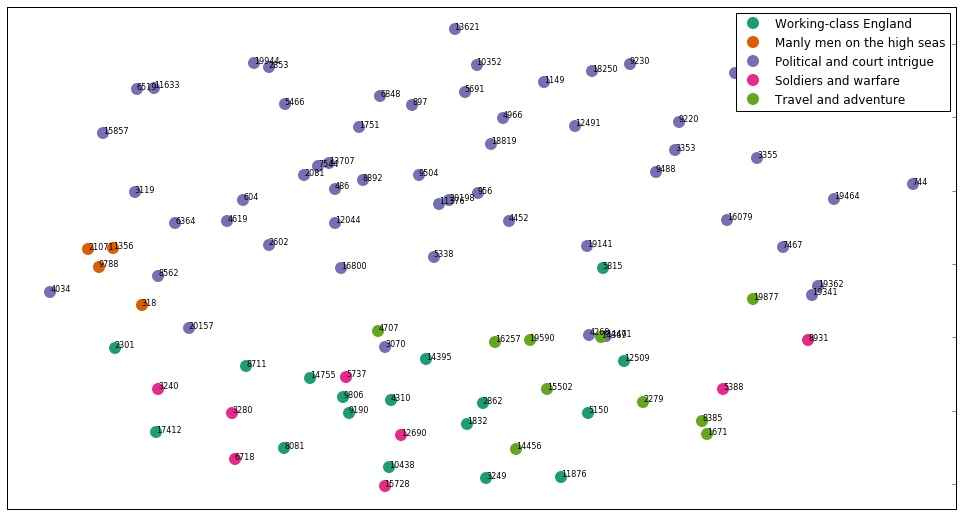

In [58]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

max_df=0.60, max_features=200000, min_df=0.40,

# Try LDA

In [59]:
import string
from gensim import corpora, models, similarities 

In [60]:
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [61]:


#remove proper names
%time preprocess = [strip_proppers(doc) for doc in books]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 1min 55s, sys: 4.83 s, total: 2min
Wall time: 2min 4s
CPU times: user 2min 13s, sys: 2.36 s, total: 2min 16s
Wall time: 2min 19s
CPU times: user 747 ms, sys: 813 ms, total: 1.56 s
Wall time: 2.01 s


In [62]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=3, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [63]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 31min 1s, sys: 31.3 s, total: 31min 32s
Wall time: 17min 34s


In [64]:
lda.show_topics()


[(0,
  '0.014*u + 0.006*king + 0.004*priest + 0.004*lord + 0.004*laird + 0.004*palac + 0.004*garden + 0.003*slave + 0.003*templ + 0.003*god'),
 (1,
  '0.006*boat + 0.005*ve + 0.003*camp + 0.003*rock + 0.003*river + 0.003*sir + 0.002*trail + 0.002*dollar + 0.002*mountain + 0.002*shot'),
 (2,
  '0.004*sir + 0.003*church + 0.003*de + 0.002*honour + 0.002*sister + 0.002*gentlemen + 0.002*languag + 0.002*nobl + 0.001*squir + 0.001*marriag'),
 (3,
  '0.010*ve + 0.004*wo + 0.004*doctor + 0.004*sir + 0.003*captain + 0.003*exclaim + 0.002*afternoon + 0.002*guess + 0.002*yes + 0.002*sister'),
 (4,
  '0.014*lord + 0.014*ship + 0.009*therefor + 0.008*nation + 0.006*bill + 0.005*trade + 0.004*employ + 0.004*board + 0.004*propos + 0.004*govern')]

In [65]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [66]:
topics_matrix

[(0,
  [('u', 0.014101064487116347),
   ('king', 0.0058648379897924688),
   ('priest', 0.0041674138161174913),
   ('lord', 0.0039080244756440142),
   ('laird', 0.0037749197642413658),
   ('palac', 0.0037444275752874586),
   ('garden', 0.0036854924606079106),
   ('slave', 0.0031832069175623274),
   ('templ', 0.0031688734896579067),
   ('god', 0.0029831066181157445),
   ('hae', 0.002864978802993778),
   ('gate', 0.0026203125315118086),
   ('queen', 0.002408167596184849),
   ('flower', 0.0023665500300473646),
   ('divin', 0.0021911678290211169),
   ('princess', 0.0021729371330304402),
   ('therefor', 0.0021293046395471182),
   ('wad', 0.0021187098945897628),
   ('wine', 0.0020285144679636222),
   ('rock', 0.0019748054581141669)]),
 (1,
  [('boat', 0.0059454406632673349),
   ('ve', 0.0046766665580444981),
   ('camp', 0.0034157301156608234),
   ('rock', 0.0029673748558815129),
   ('river', 0.0027371523347727426),
   ('sir', 0.0026884030873806589),
   ('trail', 0.0024978342114993072),
   ('d

In [68]:
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

ValueError: setting an array element with a sequence

# Visualizing LDA??

In [ ]:
print(lda.shape)

In [ ]:
lda

# Advanced K-Means visuals

In [53]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [67]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)